In [1]:
import torch
from src.config import RunConfig
from ipywidgets import Text, VBox
import PIL
from src.euler_scheduler import MyEulerAncestralDiscreteScheduler
from diffusers.pipelines.auto_pipeline import AutoPipelineForImage2Image
from src.sdxl_inversion_pipeline import SDXLDDIMPipeline
from PIL import Image
from diffusers.utils.torch_utils import randn_tensor
from IPython.display import display

/usr/local/lib/python3.8/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
def inversion_callback(pipe, step, timestep, callback_kwargs):
    return callback_kwargs


def inference_callback(pipe, step, timestep, callback_kwargs):
    return callback_kwargs

def center_crop(im):
    width, height = im.size  # Get dimensions
    min_dim = min(width, height)
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    return im


def load_im_into_format_from_path(im_path):
    return center_crop(PIL.Image.open(im_path)).resize((512, 512))

In [3]:
class ImageEditorDemo:
    def __init__(self, pipe_inversion, pipe_inference, input_image, description_prompt, cfg):
        self.pipe_inversion = pipe_inversion
        self.pipe_inference = pipe_inference
        self.original_image = load_im_into_format_from_path(input_image).convert("RGB")
        self.load_image = True
        g_cpu = torch.Generator().manual_seed(7865)
        img_size = (512,512)
        VQAE_SCALE = 8
        latents_size = (1, 4, img_size[0] // VQAE_SCALE, img_size[1] // VQAE_SCALE)
        noise = [randn_tensor(latents_size, dtype=torch.float16, device=torch.device("cuda:0"), generator=g_cpu) for i
                 in range(cfg.num_inversion_steps)]
        pipe_inversion.scheduler.set_noise_list(noise)
        pipe_inference.scheduler.set_noise_list(noise)
        pipe_inversion.scheduler_inference.set_noise_list(noise)
        pipe_inversion.set_progress_bar_config(disable=True)
        pipe_inference.set_progress_bar_config(disable=True)
        self.cfg = cfg
        self.pipe_inversion.cfg = cfg
        self.pipe_inference.cfg = cfg
        self.inv_hp = [2, 0.1, 0.2]
        self.edit_cfg = 1.2

        self.pipe_inference.to("cuda")
        self.pipe_inversion.to("cuda")

        self.last_latent = self.invert(self.original_image, description_prompt)
        self.original_latent = self.last_latent

    def invert(self, init_image, base_prompt):
        res = self.pipe_inversion(prompt=base_prompt,
                             num_inversion_steps=self.cfg.num_inversion_steps,
                             num_inference_steps=self.cfg.num_inference_steps,
                             image=init_image,
                             guidance_scale=self.cfg.guidance_scale,
                             callback_on_step_end=inversion_callback,
                             strength=self.cfg.inversion_max_step,
                             denoising_start=1.0 - self.cfg.inversion_max_step,
                             inv_hp=self.inv_hp)[0][0]
        return res

    def edit(self, target_prompt):
        image = self.pipe_inference(prompt=target_prompt,
                            num_inference_steps=self.cfg.num_inference_steps,
                            negative_prompt="",
                            callback_on_step_end=inference_callback,
                            image=self.last_latent,
                            strength=self.cfg.inversion_max_step,
                            denoising_start=1.0 - self.cfg.inversion_max_step,
                            guidance_scale=self.edit_cfg).images[0]
        return image

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_size = (512,512)
scheduler_class = MyEulerAncestralDiscreteScheduler
pipe_inversion = SDXLDDIMPipeline.from_pretrained("stabilityai/sdxl-turbo", use_safetensors=True, safety_checker= None, cache_dir="/inputs/huggingface_cache"). to(device)
pipe_inference = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", use_safetensors=True, safety_checker= None, cache_dir="/inputs/huggingface_cache"). to(device)
pipe_inference.scheduler            = scheduler_class.from_config(pipe_inference.scheduler.config)
pipe_inversion.scheduler            = scheduler_class.from_config(pipe_inversion.scheduler.config)
pipe_inversion.scheduler_inference  = scheduler_class.from_config(pipe_inference.scheduler.config)

config = RunConfig(num_inference_steps=4,
                   num_inversion_steps=4,
                   guidance_scale=0.0,
                   inversion_max_step=0.6)

Keyword arguments {'safety_checker': None} are not expected by SDXLDDIMPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

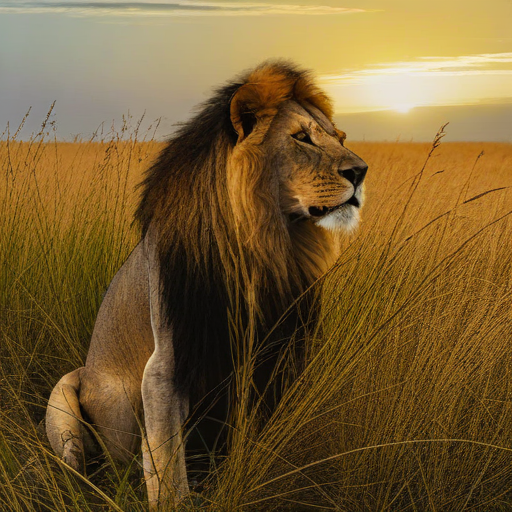

In [5]:
h = display(display_id='my-display')
input_image = "example_images/lion.jpeg"
description_prompt = 'a lion is sitting in the grass at sunset'
editor = ImageEditorDemo(pipe_inversion, pipe_inference, input_image, description_prompt, config)

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

text_input = widgets.Text(
        value=description_prompt,
        description="Prompt:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width='70%'), 
    )

def f(x):
    h.update(editor.edit(text_input.value))

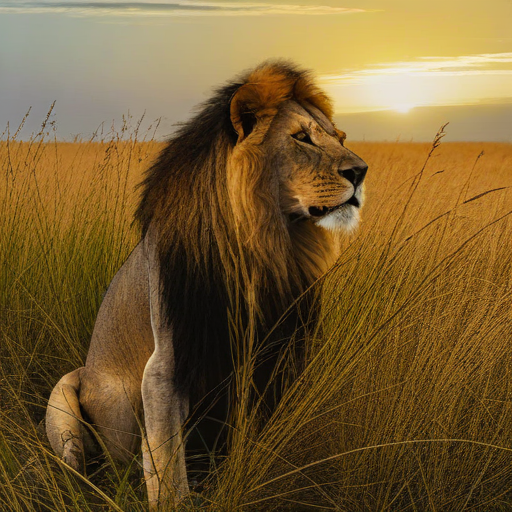

In [7]:
h.display(editor.edit(description_prompt))

In [8]:
interact_manual(f, x=text_input);
# a lion is sitting in the grass at sunset
# a raccoon is sitting in the grass at sunset
# a raccoon with a funny hat is sitting in the grass at sunset
# a raccoon with a funny hat is sitting in a green grass at sunset
# a dog with a funny hat is sitting in a green grass at sunset
# a dog with a funny red hat is sitting in a green grass at sunset.
# a dog with a funny red hat is sitting in a green grass on an overcast day.

interactive(children=(Text(value='a lion is sitting in the grass at sunset', continuous_update=False, descript…